# EDA with KTO POI data

Let's find more places you might like based on famous places in Seoul

There are a lot of nice place to visit in Seoul,  
but you are just awear the most popular places such as Namsan Tower, Namdaemun...     

It is okay,   
with basic NLP analysis, you can easily find similar place with famous place you already know

Here is simple way to go.

*data source : api.visitkorea.or.kr*


In [47]:
# import libraries
import pandas as pd
import numpy as np
import pymongo
import time
import random
import json
from pprint import pprint

import urllib.request as MyURL
from bs4 import BeautifulSoup
from datetime import datetime
from matplotlib import pyplot as plt

import pickle

In [2]:
# set mongodb connection (I used local machine)
from pymongo import MongoClient 
client = MongoClient('localhost', 27017)

In [3]:
# set database name
db = client['cp_seoul']

In [4]:
# set collection name
collection = db['seoul']

In [29]:
# key for KTO(Korea Tourism Organization) API at data.go.kr
# http://api.visitkorea.or.kr
with open('./.secrets/kto_api_key.txt', 'r') as f:
    key = f.read().strip()

#### Find places in seoul from KOT api

In [7]:
# Every place in Seoul
url = f'http://api.visitkorea.or.kr/openapi/service/rest/EngService/areaBasedList?'
url += f'ServiceKey={key}&contentTypeId=&areaCode=1&sigunguCode=&cat1=&cat2=&cat3='
url += f'&listYN=Y&MobileOS=ETC&MobileApp=TourAPI3.0_Guide&arrange=A&numOfRows=1200&pageNo=1'

In [10]:
# get data from api server
response = MyURL.urlopen(url)

In [11]:
# parsing with BS4
results = BeautifulSoup(response, "html.parser")

In [14]:
# parse and make a document for mongo db
row = 0
for result in results.findAll('items'):
    for item in result.findAll('item'):
        row += 1
        record = {}
        for i in item:
            record[i.name] = i.contents[0]
#             print(i.name, i.contents)
#         collection.insert_one(record)

print(f'{row} places collected')

1170 places collected


#### Get detail information for POI

In [15]:
# check the record
a_record = (collection.find_one({'contentid': '1266515'}))

In [17]:
# only contains general information, need to find detail
a_record

{'_id': ObjectId('5db26b80c36b1f23ca16b568'),
 'addr1': '20, Nambusunhwan-ro 64-gil, Yangcheon-gu, Seoul',
 'areacode': '1',
 'cat1': 'A02',
 'cat2': 'A0202',
 'cat3': 'A02020700',
 'contentid': '1266515',
 'contenttypeid': '76',
 'createdtime': '20110428140717',
 'firstimage': 'http://tong.visitkorea.or.kr/cms/resource/06/2611706_image2_1.bmp',
 'firstimage2': 'http://tong.visitkorea.or.kr/cms/resource/06/2611706_image2_1.bmp',
 'mapx': '126.8300634330',
 'mapy': '37.5274172505',
 'masterid': '1265735',
 'mlevel': '6',
 'modifiedtime': '20190830140812',
 'readcount': '12323',
 'sigungucode': '19',
 'tel': '+82-2-2604-3004',
 'title': 'Seoseoul Lake Park (서서울호수공원)',
 'zipcode': '07916'}

In [37]:
def get_detail(collection, content_id, type_id, key):
    """Return detail information about place"""
    """collection : mongodb collection to store"""
    """content_id, type_id : key value for place"""
    """key : api_key to access KOT api"""


    url = f'http://api.visitkorea.or.kr/openapi/service/rest/EngService/detailCommon'
    url += f'?ServiceKey={key}&contentTypeId=&contentId={content_id}&'
    url += 'MobileOS=ETC&MobileApp=TourAPI3.0_Guide&defaultYN=Y&firstImage'
    url += 'YN=Y&areacodeYN=Y&catcodeYN=Y&addrinfoYN=Y&mapinfoYN=Y&overviewYN=Y&transGuideYN=Y'
    
    response = MyURL.urlopen(url)
    results = BeautifulSoup(response, "html.parser")

    document = collection.find_one({'contentid': content_id})

#     print(url)
    for result in results.findAll('items'):
        for item in result.findAll('item'):
            for i in item:
                if len(i) > 0:
                    document[i.name] = i.contents[0]

    return document


In [38]:
get_detail(collection, '1266515', '76', key)

{'_id': ObjectId('5db26b80c36b1f23ca16b568'),
 'addr1': '20, Nambusunhwan-ro 64-gil, Yangcheon-gu, Seoul',
 'areacode': '1',
 'cat1': 'A02',
 'cat2': 'A0202',
 'cat3': 'A02020700',
 'contentid': '1266515',
 'contenttypeid': '76',
 'createdtime': '20110428140717',
 'firstimage': 'http://tong.visitkorea.or.kr/cms/resource/06/2611706_image2_1.bmp',
 'firstimage2': 'http://tong.visitkorea.or.kr/cms/resource/06/2611706_image2_1.bmp',
 'mapx': '126.8300634330',
 'mapy': '37.5274172505',
 'masterid': '1265735',
 'mlevel': '6',
 'modifiedtime': '20190830140812',
 'readcount': '12323',
 'sigungucode': '19',
 'tel': '+82-2-2604-3004',
 'title': 'Seoseoul Lake Park (서서울호수공원)',
 'zipcode': '07916',
 'directions': 'Hwagok Station (Seoul Subway Line 5), Exit 5.<br>Take Bus No. 652, 6627 or 6625, and get off at Seoseoul Lake Park Bus Stop.',
 'dongcode': '16',
 'homepage': '<a href="http://www.yangcheon.go.kr/" target="_blank" class="web" title="new window popup">www.yangcheon.go.kr</a> (Korean, Engl

#### Get detail information for all POIs

In [39]:
# set cursor
cursors = collection.find()

In [40]:
print(f'start at : {datetime.now()}')
row = 0

new_collection = db['seoul_poi']

for cursor in cursors:
    content_id = cursor['contentid']
    type_id = cursor['contenttypeid']

    row += 1
        
    poi_detail = get_detail(collection, content_id, type_id, key)
    new_collection.insert_one(poi_detail)
    print(f'{row} : update {content_id} at {datetime.now()}')
    
    # watch out for usage limit of api
    if row == 5:
        break
    
print(f'end at : {datetime.now()}')
    

start at : 2019-12-17 10:55:29.872428
1 : update 2480979 at 2019-12-17 10:55:31.087063
2 : update 1240735 at 2019-12-17 10:55:31.410975
3 : update 2444381 at 2019-12-17 10:55:31.777388
4 : update 2009231 at 2019-12-17 10:55:32.102341
5 : update 2542774 at 2019-12-17 10:55:32.478214
end at : 2019-12-17 10:55:32.478439


In [48]:
# Retrieve data sample(경복궁)
new_collection = db['seoul_poi']
cursors = new_collection.find({'contentid': '264337'})

In [49]:
for cursor in cursors:
    cursor.pop('_id')
    app_json = json.dumps(cursor, sort_keys=True)
    pprint(app_json)

('{"addr1": "161, Sajik-ro, Jongno-gu, Seoul", "areacode": "1", "cat1": "A02", '
 '"cat2": "A0201", "cat3": "A02010100", "contentid": "264337", '
 '"contenttypeid": "76", "createdtime": "20110225172850", "directions": '
 '"[Subway]<br />\\nGyeongbokgung Station (Seoul Subway Line 3) and Exit '
 '5.<br/>\\nAnguk Station (Seoul Subway Line 3) and Exit 1. <br /><br '
 '/>\\n\\n[Bus]<br />\\nTake Bus No. 1020, 7025,109, 171, 172, 601 or 606 and '
 'get off at Gyeongbokgung Palace Bus Stop.<br /><br />\\n\\nTake Jongno Bus '
 'No. 11 and get off at National Folk Musuem of Korea Bus Stop.", "dongcode": '
 '"36", "firstimage": '
 '"http://tong.visitkorea.or.kr/cms/resource/40/1568040_image2_1.jpg", '
 '"firstimage2": '
 '"http://tong.visitkorea.or.kr/cms/resource/40/1568040_image3_1.jpg", '
 '"homepage": "<a title=\\"New window popup\\" '
 'href=\\"http://www.royalpalace.go.kr/\\" '
 'target=\\"_blank\\">www.royalpalace.go.kr</a> (Korean, English)<br>\\n <a '
 'title=\\"New window popup\\" hr

### Understanding the dataset

In [50]:
# Put the data into dataframe
cursor = new_collection.find()

# Expand the cursor and construct the DataFrame
df =  pd.DataFrame(list(cursor))

# Delete the _id
del df['_id']


In [54]:
df.head(3).T

,0,1,2
addr1,"38, Donggyo-ro 29-gil, Mapo-gu, Seoul","31, Daehak-ro 12-gil, Jongno-gu, Seoul","3rd floor, 26, Eulji-ro 9-gil, Jung-gu, Seoul"
addr2,NaN,NaN,NaN
areacode,1,1,1
cat1,A05,A02,B02
cat2,A0502,A0206,B0201
cat3,A05020900,A02060600,B02010900
contentid,2480979,1240735,2444381
contenttypeid,82,78,80
createdtime,20170214145634,20110324102837,20161201153253
directions,[Subway]<br />\nHongik Univ. Station (Seoul Su...,[Subway]<br>Haehwa Station (Seoul Subway Line ...,Available


In [55]:
# find Bongeunsa
cursor = new_collection.find({'title': {"$regex": u"Bongeunsa"}})

In [56]:
for row in cursor:
    print(row['title'], row['contentid'])

Bongeunsa Temple (Seoul) (봉은사 (서울)) 264594


In [58]:
# Ref) type_id values
content_types = {
    82: "음식(82)Dining",
    76: "관광지(76)TouristAttractions",
    79: "쇼핑(79)Shopping",
    78: "문화시설(78)Cultural Facilities",
    80: "숙박(80)Accommodation",
    85: "축제/공연/행사(85)Festivals/Events/Performances",
    75: "레포츠(75)Leisure/Sports",
    77: "교통(77)Transportation",    
}

In [59]:
# Histogram for readcount
content_type_count = df.contenttypeid.value_counts()

In [60]:
content_type_count

82    263
76    262
79    215
78    161
80    156
85     87
75     26
77     11
Name: contenttypeid, dtype: int64

In [61]:
# example of filtering - only Dining 
for _, row in df.iterrows():
    if row['contenttypeid'] == '82':
        print(row['title'])

17℃ (17도씨)
63 Buffet Pavilion (63뷔페 파빌리온)
Aedogin (에도긴)
Ali Baba (알리바바)
Alla Prima (알라 프리마)
Andong Guksi (안동국시)
Aoi Tori (아오이토리)
Areumdaun Cha Bangmulgwan (Beautiful Tea Museum) (아름다운차박물관)
Arirang (아리랑)
B-hind (비하인드)
Baba India - Gangnam Branch (바바인디아 (강남역점))
Badalbi (바달비)
Baekje Samgyetang (백제삼계탕)
Baengnyeon Samgyetang (백년토종삼계탕)
Baengnyeonok (백년옥)
Baerlin (베어린)
Balwoo Gongyang (사찰음식 전문점 발우공양)
Bistro74 (비스트로74)
Bo Reum Soei (보름쇠)
Bongpiyang (Bangi Branch) (봉피양 방이점)
Bongraeheon (Mayfield Hotel) (봉래헌(메이필드호텔))
Bua (부아)
Buchon Yukhoe (부촌육회)
Bugakjeong Isang Galbi (북악정-이상갈비)
Bugeogukjip (북어국집)
Bukmakgol (북막골)
BuonaSera (보나세라)
Busan Sikdang (부산식당)
Busanbokjip (부산복집)
Ca'del Lupo (까델루뽀)
Cacao Boom (Itaewon Branch) (카카오봄(이태원점))
Cacaodada (카카오 다다)
Café De Paris (카페드파리)
Café Moon (달 카페)
Canadian Lobster (카나디안 랍스터)
Châtaigne (샤떼뉴)
Chakraa (Hannam Branch) (차크라(한남점))
Chammanna (참만나)
Chamsutgol (참숯골)
Chanyangjip (찬양집)
Cheongsu Hoetjip (Formerly Eushim) (청수횟집)
Chikibaitu (Chickyx2) - Ewha Woman's Univ

### Data on the MAP

Visualization with folium

In [62]:
import folium

In [63]:
df.mapx = pd.to_numeric(df.mapx)

In [64]:
df.mapy = pd.to_numeric(df.mapy)

In [65]:
center_coord = (df.mapy.mean(), df.mapx.mean())

In [66]:
center_coord

(37.51909343531988, 126.88651275411688)

In [67]:
f_map = folium.Map(location=center_coord, zoom_start=12)

In [68]:
for _, row in df.iterrows():
    
    icon = folium.Icon(color='blue')
    if row['contenttypeid'] == '82':
        # Food
        icon.color = 'red'
    elif row['contenttypeid'] == '76':
        # 관광지
        icon.color = 'green'
    elif row['contenttypeid'] == '79':
        # 쇼핑
        icon.color = 'orange'
    elif row['contenttypeid'] == '80':
        # 숙박
        icon.color = 'purple' 
    
    if not (np.isnan(row['mapy']) or np.isnan(row['mapx'])):
        folium.Marker(location=[row['mapy'], row['mapx']], 
                      popup=row['title'], 
                      icon=icon).add_to(f_map)
    else:
        # show no content type places
        print(row['title'])


Art Korea Inc.(아트코리아)
Hapjeong-dong Café Street (합정동 카페거리)
International Seon Center (국제선센터)
Inwoo House (인우하우스)


In [70]:
display(f_map)

### Vectorizing by TD-IDF values with overview

In [71]:
# import libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import stop_words
from sklearn.decomposition import TruncatedSVD

from nltk.tokenize import word_tokenize

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [72]:
# make n grams
ngrams_1 = {
    'ngram_range': (1, 1),
    'stop_words': 'english',
    'dtype': 'int32',
    'strip_accents': 'unicode',
    'decode_error': 'replace',
    'analyzer': 'word',
    'min_df': 2
}

In [73]:
tfidf = TfidfVectorizer(ngrams_1)

In [75]:
# Replace NA with ''
df.overview = df.overview.fillna('')

In [76]:
overviews = list(df['overview'])

In [77]:
overviews[:5]

['17℃ stands for the optimum temperature to preserve chocolates at its best quality. Presenting a wide variety of hand-made chocolates, purchasable items include chocolate bars and café menus like chocolate cakes and chocolate beverages. In particular, you can control the amount of cacao in your chocolate drink ranging from 40%~80% according to your preference.',
 '1m Classic Art Hall, located in Daehang-ro is a classic art experience center exclusively for children. The center provides children with the opportunity to enjoy classical music in a fun and interesting way. In the ‘1m Experience Classic’ program (the oldest children’s classical program in the nation), teachers not only provide interesting mini-music learns, but also assist children in trying out a variety of instruments.<br><br>\n\nAt the performance halls at the 1m Classic Art Hall, the stage is just 1m away from the surrounding seats, giving young audience members a more intimate musical experience.',
 "Situated in the m

In [79]:
# get TF-IDF values
tfidf_values = tfidf.fit_transform(df['overview'])

In [80]:
tfidf_values.shape

(1181, 9988)

In [81]:
# Reduce dimensions for Chart
svd = TruncatedSVD(n_components=3)
svd_values = svd.fit_transform(tfidf_values)

In [82]:
svd_values

array([[ 0.14462705, -0.00662936,  0.07430951],
       [ 0.24511804, -0.06139667, -0.04493281],
       [ 0.41434115,  0.16218018, -0.00816787],
       ...,
       [ 0.        , -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        ],
       [ 0.        , -0.        ,  0.        ]])

In [83]:
# dump vectors to file with pickle
# for deployment
with open('poi_vectors', 'wb') as f:
    pickle.dump(svd_values, f)
    

In [84]:
with open('poi_df', 'wb') as f:
    pickle.dump(df, f)

In [85]:
# Coloring by category: Food : Red, Sightseeing : Green, Shopping : Blue, Lodging : Purple
C = []
for idx, row in df.iterrows():    
    if row['contenttypeid'] == '82':
        # Dining
        C.append('r')
    elif row['contenttypeid'] == '76':
        # Attraction
        C.append('g')
    elif row['contenttypeid'] == '79':
        # Shopping
        C.append('b')
    elif row['contenttypeid'] == '80':
        # Accomodation
        C.append('purple')
    else:
        C.append('gray')
        

In [86]:
# Set list for chart (X, Y, Z and Colors)
X = []
Y = []
Z = []
CC = []

for idx, c in enumerate(['r', 'g', 'b', 'purple', 'gray']):
    x = []
    y = []
    z = []
    cc = []
    for id, i in enumerate(svd_values):
        if C[id] == c:
            x.append(i[0])
            y.append(i[1])            
            z.append(i[2])
            cc.append(C[idx])
    X.append(x)
    Y.append(y)
    Z.append(z)
    CC.append(cc)

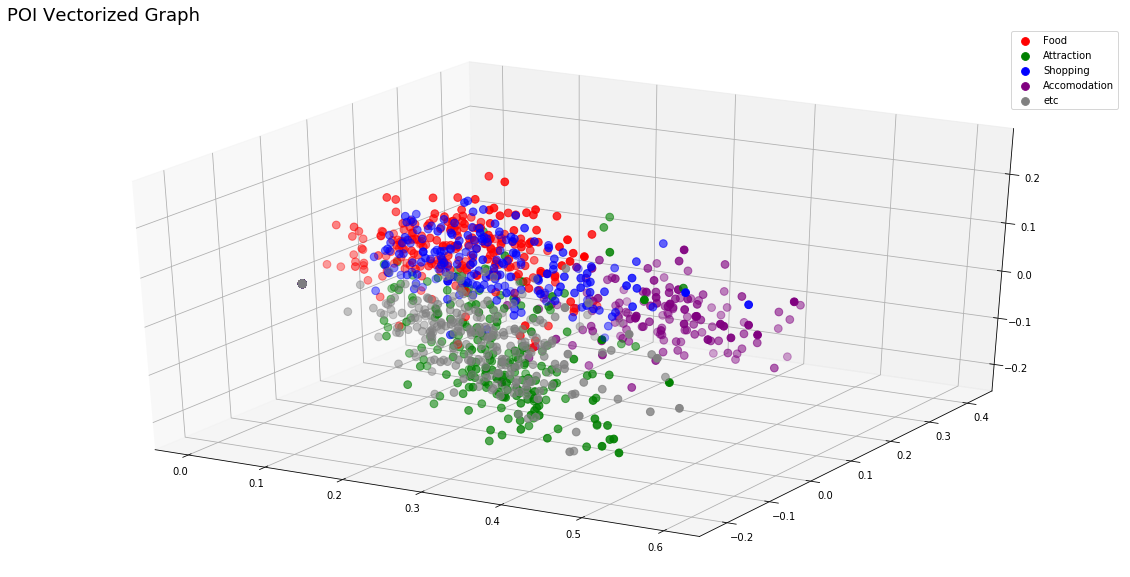

In [87]:
fig = plt.figure(figsize=(20,10))
labels = ['Food', 'Attraction', 'Shopping', 'Accomodation', 'etc']
ax = fig.add_subplot(111, projection='3d')
for idx, c in enumerate(['r', 'g', 'b', 'purple', 'gray']):
    ax.scatter(X[idx], Y[idx], Z[idx], color=c, s=60, label=labels[idx])

ax.legend()
ax.set_title('POI Vectorized Graph', fontdict={'fontsize': 18}, loc='left')
plt.show()


#### Compare vectors

In [88]:
# Find index value for POI (with keyword '강남')
df[df['title'].str.contains('강남')][['title', 'contentid', 'overview']]

,title,contentid,overview
51,Baba India - Gangnam Branch (바바인디아 (강남역점)),556174,Baba India is a traditional Indian cuisine res...
72,Best Western Premier Gangnam Hotel (베스트웨스턴 프리미...,782947,Best Western International is a worldwide chai...
293,Gangnam (강남),264571,Gangnam Subway Station area is the prime distr...
294,Gangnam Station Underground Shopping Center (강...,2021659,Consumers in their 20s to 30s are frequent vis...
320,Goto Mall (Gangnam Terminal Underground Shoppi...,1356028,Gangnam Terminal Underground Shopping Center i...
562,Kakao Friends Gangnam Flagship Store (카카오프렌즈 강...,2579444,Kakao Friends Gangnam Flagship Store features ...
606,Kumkang - Gangnam Branch (Main store) (금강제화 (강...,1326661,Kumkang Shoes is Korea's leading fashion retai...
784,"Novotel Ambassador Gangnam, Seoul (노보텔 앰배서더 강남)",349257,"The Novotel Ambassador Gangnam, Seoul is one o..."
995,Seven Luck Casino - Gangnam COEX (세븐럭카지노(강남코엑스점)),495641,"Everyone’s favorite, Korean Las Vegas – Seven ..."
999,Sheraton Seoul Palace Gangnam Hotel (쉐라톤 서울 팔래...,349263,


In [89]:
# Get distance between 2 places
X = [i[0] for i in svd_values]
Y = [i[1] for i in svd_values]
Z = [i[2] for i in svd_values]

def compare_vectors(idx_1, idx_2):
    """Return distance and values for place 1 and 2"""
    value_a = (X[idx_1], Y[idx_1], Z[idx_1])
    value_b = (X[idx_2], Y[idx_2], Z[idx_2])
    
    # !!!!check how to get_distance between 3d vectors
    diff = abs(X[idx_1] - X[idx_2]) + abs(Y[idx_1] - Y[idx_2]) + abs(Z[idx_1] - Z[idx_2])
    
    return diff, value_a, value_b

In [90]:
# Palace vs Namsan Tower (경복궁 vs 남산타워)
compare_vectors(359, 748)

(0.3223364536090081,
 (0.38349766570740146, -0.18816441830466987, -0.13631551868256736),
 (0.2859587928233404, -0.02282721000838683, -0.0768551462539034))

In [91]:
# Palace vs Palace (경복궁 vs 창경궁)
compare_vectors(359, 133)

(0.12912384645491087,
 (0.38349766570740146, -0.18816441830466987, -0.13631551868256736),
 (0.49915939725264324, -0.19077022695594983, -0.12545921242417823))

In [92]:
# Namsan Tower vs Lotte World Tower (남산타워 vs 롯데월드타워)
compare_vectors(748, 653)

(0.2073757677157045,
 (0.2859587928233404, -0.02282721000838683, -0.0768551462539034),
 (0.4288209277809683, -0.070632393935365, -0.06014669742280494))

In [93]:
# Traditional Village vs Gangnam area (북촌한옥마을 vs 강남)
compare_vectors(98, 293)

(0.34024142153253645,
 (0.2812253688776428, -0.0703116829225088, 0.048707657258436454),
 (0.36964328242548494, 0.06774537303918675, -0.06505879476456233))

#### Make function for get similar places

In [94]:
# extract vectors to tuple array
vectors = [(i[0], i[1], i[2]) for i in svd_values]

In [95]:
# get similar places function
def get_similar(index):
    """Returns similar places of indiced place"""
    X = vectors[index][0]
    Y = vectors[index][1]
    Z = vectors[index][2]
 
    distances = []
    for i, value in enumerate(vectors):
        distance = (abs(X - value[0]) + abs(Y - value[1]) + abs(Z - value[2]), i)
        distances.append(distance)

    top5_similars = [i[1] for i in sorted(distances)[0:6]]
    
    distance_df = pd.DataFrame(distances)
    
    result = pd.DataFrame(df.loc[top5_similars][['title', 'contentid', 'overview']])
    result = pd.merge(result, distance_df.loc[top5_similars], left_index=True, right_index=True)
    
    result = result.rename({0:'distance'}, axis='columns')

    return result


#### Get similar places

In [96]:
# Bukchon Hanok Village
get_similar(98)

,title,contentid,overview,distance,1
98,Bukchon Hanok Village (북촌한옥마을),561382,"Surrounded by Gyeongbokgung Palace, Changdeokg...",0.000000,98
71,Beautiful Tea Museum (아름다운 차박물관),268218,"Located in Insa-dong, The Beautiful Tea Museum...",0.020421,71
936,Seoul Folk Flea Market - Traditional Arts & C...,1371199,The Traditional Arts & Crafts Studio at Seoul ...,0.032491,936
480,Injeongwon - Gildong Main Branch (인정원-길동본점),554553,"'Vietnamssam Injeongwon,' keeping the new tren...",0.051418,480
600,Korean Museum of Straw and Life (짚풀생활사박물관),2603951,Korean Museum of Straw and Life is a private m...,0.052609,600
818,Passion 5 (패션5),1151309,Passion 5 is located near Hangangjin Station i...,0.058452,818


In [97]:
# Namsan Seoul Tower
get_similar(748)

,title,contentid,overview,distance,1
748,Namsan Seoul Tower (남산서울타워),264550,Namsan Seoul Tower was the first tower-type to...,0.000000,748
755,Nanji Hangang Park (Nanji Camping Site) (한강시민공...,767100,"As part of the Hangang Renaissance project, Na...",0.027041,755
161,Children’s Grand Park (서울 어린이대공원),1051832,"Situated in Gwangjin-gu, Seoul Children’s Gran...",0.041662,161
217,Dobongsan Mountain (도봉산),1742421,"Dobongsan Mountain, located northeast of Bukha...",0.044465,217
1043,Suraksan Mountain (수락산),1253587,Along with the other great mountains near Seou...,0.044980,1043
664,Mapo Art Center (마포아트센터),1145438,Mapo Art Center is an innovative cultural art ...,0.045457,664


In [98]:
# Lotte World Tower Seoul Sky
get_similar(653)

,title,contentid,overview,distance,1
653,Lotte World Tower Seoul Sky (롯데월드타워 서울스카이),2493015,Seoul Sky is located on floors 117-123 of Lott...,0.000000,653
886,Sang Sang Tok Tok Gallery (상상톡톡 미술관),1114538,"The Children’s Gallery, located in Seoul’s ‘No...",0.047512,886
387,Hangaram Art Museum in Seoul Arts Center (예술의전...,1312802,"Hangaram Art Museum, located in the left wing ...",0.053813,387
872,Samcheonggak (삼청각),268177,Reflecting its name (literally the ‘House with...,0.054991,872
721,Myeongdong Nanta Theatre (명동난타극장),651452,The Myeongdong Nanta Theatre is located on the...,0.059575,721
338,Gwanaksan Mountain (관악산),1562674,"At 632.2 meters in x_height, Gwanaksan Mountai...",0.067633,338


In [99]:
# Gyeongbokgung Palace 
get_similar(359)

,title,contentid,overview,distance,1
359,Gyeongbokgung Palace (경복궁),264337,"Built in 1395, Gyeongbokgung Palace is also co...",0.000000,359
710,"Museum of Art, Seoul National University (서울대학...",1752538,"Museum of Art, Seoul National University was e...",0.044925,710
245,Doseonsa Temple (도선사),1348684,"Doseonsa Temple was established 1,100 years ag...",0.044927,245
964,Seoul Museum of History (서울역사박물관),268127,Seoul Museum of History captures the tradition...,0.047834,964
147,Cheonggyecheon Museum (청계천박물관),268210,The Cheonggyecheon Museum officially opened on...,0.055322,147
342,Gwanghwamun Gate (광화문),264329,"Built in 1395 under the reign of King Taejo, t...",0.055455,342


#### TF-IDF gives meaningful result about similarity between POIs, let's make a web app with this model